# Analyze results from the groundwater modeling challenge

In this notebook, the results from the groundwater modeling challenge are analyzed.

0. Load Python packages
1. Load all data

*Author: R.A. Collenteur, December 2023*

### 0. Load Python packages

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import matplotlib.colors as mcolors

from matplotlib.gridspec import GridSpec
ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.10.13
NumPy version: 1.23.5
Pandas version: 2.1.4
SciPy version: 1.11.4
Matplotlib version: 3.8.0
Numba version: 0.58.1
LMfit version: Not Installed
Latexify version: Not Installed
Pastas version: 1.1.0


### 1. Load data

In [2]:
name_sort = {'Lumped':0,'ML':1,'DL':2}

teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.drop("runwaygrey")  # Results do not seem correct, so not considered further
teams = teams.drop("regression")  # Opted out of challenge
order = [str(name) for name in teams.loc[:, ("General Info", "Type")].map(name_sort).sort_values().index.astype(str)]
order

['da_collective',
 'gardenia',
 'HydroSight',
 'Janis',
 'Mirkwood',
 'Selina_Yang',
 'MxNl',
 'GEUS',
 'LUHG',
 'M2C_BRGM',
 'TUD',
 'RouhaniEtAl',
 'TUV',
 'haidro',
 'uw']

### Start and end of validation period

In [3]:
tmin = {
    "Netherlands": "2016-09-23",
    "USA": "2017-01-18",
    "Germany": "2017-01-01",
    #"Sweden_1": "2016-01-05",
    "Sweden_2": "2016-01-05",
}

tmax = {
    "Netherlands": "2020-11-27",
    "USA": "2021-12-31",
    "Germany": "2021-12-31",
    #"Sweden_1": "2020-12-29",
    "Sweden_2": "2020-12-29",
}

In [4]:
sims = pd.read_csv("../data/all_results.csv", index_col=0, parse_dates=True, header=[0, 1, 2])

wells = sims.columns.get_level_values(1).unique().drop("Sweden_1")
names = ['USA', 'Netherlands', 'Germany', 'Sweden']

heads = []

for well in wells:
    head = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                       index_col=0, parse_dates=True).squeeze().dropna()
    head.index = head.index.round("D")    
    head.name = well
    heads.append(head.loc[~head.index.duplicated()])

heads = pd.concat(heads, axis=1)
heads = heads.loc[~heads.index.duplicated()]

## Compute goodness-of-fit metrics

In [5]:
stats = ["mae", "rmse", "nse", "kge_2012"]
team_names = sims.columns.get_level_values(0).unique()
periods = ["calibration", "validation"]

mi = pd.MultiIndex.from_product([periods, stats, wells])
metrics = pd.DataFrame(index=team_names, columns=mi, dtype=float)

for i, well in enumerate(wells):
    head = heads.loc[:, well].dropna()    
    sim = sims.loc[:, (slice(None), well, "Simulated Head")].astype(float)
    
    for name, ts in sim.items():
        for period in periods:
            if period == "calibration":
                tn = "2000-01-01"
                tx = tmin[well]
            else:
                tn = tmin[well]
                tx = tmax[well]
            
            if ts.dropna().empty:
                pass
            else:
                s = ts.loc[ts.index.drop_duplicates()].dropna()
                idx = head.loc[tn:tx].dropna().index.intersection(s.dropna().index)
    
                h = head.loc[idx]
                s = s.loc[idx]
    
                for stat in stats:
                    metrics.loc[name[0], (period, stat, well)] = getattr(ps.stats.metrics, stat)(obs=h, sim=s)
    
                metrics.loc[name[0], (period, "mae_20", well)] = ps.stats.metrics.mae(h[h<h.quantile(0.2)], s)
                metrics.loc[name[0], (period, "mae_80", well)] = ps.stats.metrics.mae(h[h>h.quantile(0.8)], s)

            # Compute the PICP values
            bounds = sims.loc[tn:tx, pd.IndexSlice[name[0], well, ["95% Lower Bound", "95% Upper Bound"]]]
            if not bounds.dropna().empty:
                nobs_between = h.between(bounds.loc[h.index].iloc[:,0], bounds.loc[h.index].iloc[:,1]).sum()
                nobs = h.index.size
                metrics.loc[name[0], (period, "PICP", well)] = nobs_between / nobs
            else: 
                metrics.loc[name[0], (period, "PICP", well)] = np.nan

metrics.head()

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_73715/3295455816.py:41: RuntimeWarning: invalid value encountered in scalar divide
  metrics.loc[name[0], (period, "PICP", well)] = nobs_between / nobs


calibration                                                      \
                      mae                                      rmse             
Team          Netherlands   Germany  Sweden_2       USA Netherlands   Germany   
da_collective    0.022160  0.054337  0.185790  0.159448    0.030193  0.076495   
GEUS             0.022899  0.075632  0.225647  0.083811    0.035912  0.111290   
Janis            0.004953  0.009409  0.074544  0.012606    0.008026  0.015713   
LUHG             0.051337  0.129774  0.404825  0.269270    0.063827  0.180342   
M2C_BRGM         0.030728  0.100769  0.508942  0.170609    0.039291  0.131825   

                                                         ...            \
                                          nse            ...      PICP   
Team           Sweden_2       USA Netherlands   Germany  ...  Sweden_2   
da_collective  0.243493  0.205656    0.924206  0.940789  ...  0.348214   
GEUS           0.318920  0.127299    0.892773  0.874671  ...  0.984694   
Janis          0.105181  0.024458    0.994644  0.997502  ...  0.918367   
LUHG           0.589031  0.351047    0.661289  0.670898  ...  0.910714   
M2C_BRGM       0.646517  0.224527    0.874884  0.828538  ...  0.305864   

              validation                     calibration                      \
                  mae_20    mae_80      PICP      mae_20    mae_80      PICP   
Team            Sweden_2  Sweden_2  Sweden_2         USA       USA       USA   
da_collective   0.254547  0.983437  0.678161    0.124126  0.177238  0.513570   
GEUS            0.196659  0.987527  0.777778    0.074238  0.101945  0.987284   
Janis           0.397493  0.912415  0.203065    0.010743  0.016672  0.994876   
LUHG            0.154859  1.750309  0.773946    0.295970  0.380822  0.974189   
M2C_BRGM        0.666581  0.990332  0.371648    0.302173  0.095135  0.669077   

              validation                      
                  mae_20    mae_80      PICP  
Team                 USA       USA       USA  
da_collective   0.456812  0.199612  0.984780  
GEUS            0.310505  0.204975  0.928410  
Janis           0.145504  0.190073  0.417136  
LUHG            0.359262  0.404043  0.947012  
M2C_BRGM        0.237110  0.103083  0.725479  

[5 rows x 56 columns]

## Write latex table

In [6]:
# table = metrics.loc[:, (["nse", "mae"], slice(None))].astype(float).style.background_gradient(cmap="RdBu")
# table.to_latex("../tables/fit_metrics.tex")
# table

## Define plotting function 

In [7]:
# Reverse once here..
order.reverse()
order

['uw',
 'haidro',
 'TUV',
 'RouhaniEtAl',
 'TUD',
 'M2C_BRGM',
 'LUHG',
 'GEUS',
 'MxNl',
 'Selina_Yang',
 'Mirkwood',
 'Janis',
 'HydroSight',
 'gardenia',
 'da_collective']

In [8]:
def plot_metrics(metric, label, best="max"):
    """
    Parameters
    ----------
    best: str
        'max' for when the maximum is the best, 'min' for the opposite.

    """
    fig = plt.figure(figsize=(5,5),  layout="tight")
    spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

    top = []
    axes =[]
    axb = None
    axt = None

    for i in range(4):
        if axb is not None:
            axb = fig.add_subplot(spec[2:16, i], sharey=axb)
        else:
            axb = fig.add_subplot(spec[2:16, i])

        axes.append(axb)

        if axt is not None:
            axt = fig.add_subplot(spec[0:2, i], sharex=axb)
        else:
            axt = fig.add_subplot(spec[0:2, i], sharex=axb)

        top.append(axt)

    # Get metrics values
    m = metrics.loc[order, (slice(None), metric, wells)]
    m.columns = m.columns.droplevel([1])
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    if best == "min":
        rank = m.abs().rank()
    elif best == "max":
        rank = m.rank(ascending=False)

    for i, well in enumerate(wells):
        ax = axes[i]
        ax.set_title("")
        ax.grid(zorder=-10)
        
        props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
        b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                               widths=0.8, color=props, patch_artist=True)
        b.patches[0].set_alpha(0.5)
        top[i].set_yticklabels(["Calibration", "Validation"])
        top[i].set_title(None)
        
        m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
             color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

        if best == "min":
            x, y = m.loc[order, ("validation", well)].abs().max(), m.loc[order, ("validation", well)].argmin()
        elif best == "max":
            x, y = m.loc[order, ("validation", well)].abs().max(), m.loc[order, ("validation", well)].argmax()
            
        axes[i].scatter(x, y, 
                        marker="*", color="gold", zorder=200, edgecolor="k", s=50)
        top[i].set_title(well.split("_")[0], fontsize=10)
        axes[i].set_xlim(0)

        for row, val in enumerate(rank.loc[order, ("validation", well)].values):
            if np.isnan(val):
                pass
            else:
                axes[i].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                             bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})
    
    # Annotate model groups
    y = 0.71
    plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
    y = 0.56
    plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
    y = 0.3
    plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

    fig.text(0.5, 0.02, label, horizontalalignment="center")
    return fig, axes

### Figure 02: NSE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_73715/1408853691.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_02.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


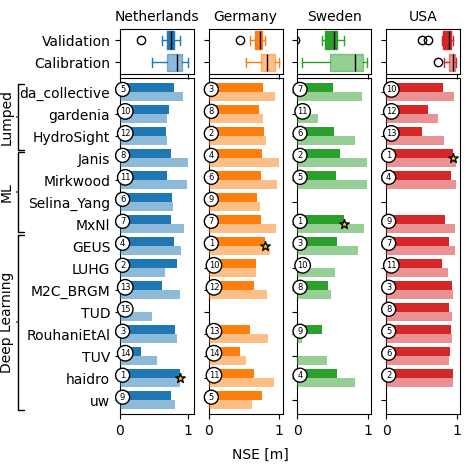

In [9]:
plot_metrics("nse", label="NSE [m]", best="max")
plt.savefig("../figures/figure_02.png", bbox_inches="tight", dpi=300)

### Figure 03: MAE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_73715/1106482698.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_03.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


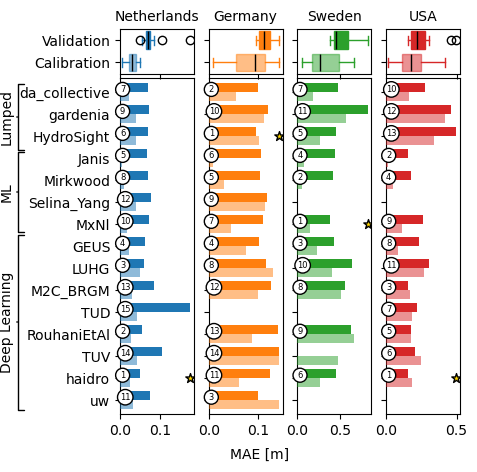

In [10]:
plot_metrics("mae", label="MAE [m]", best="min")
plt.savefig("../figures/figure_03.png", bbox_inches="tight", dpi=300)

### Figure 04: Best model of each category

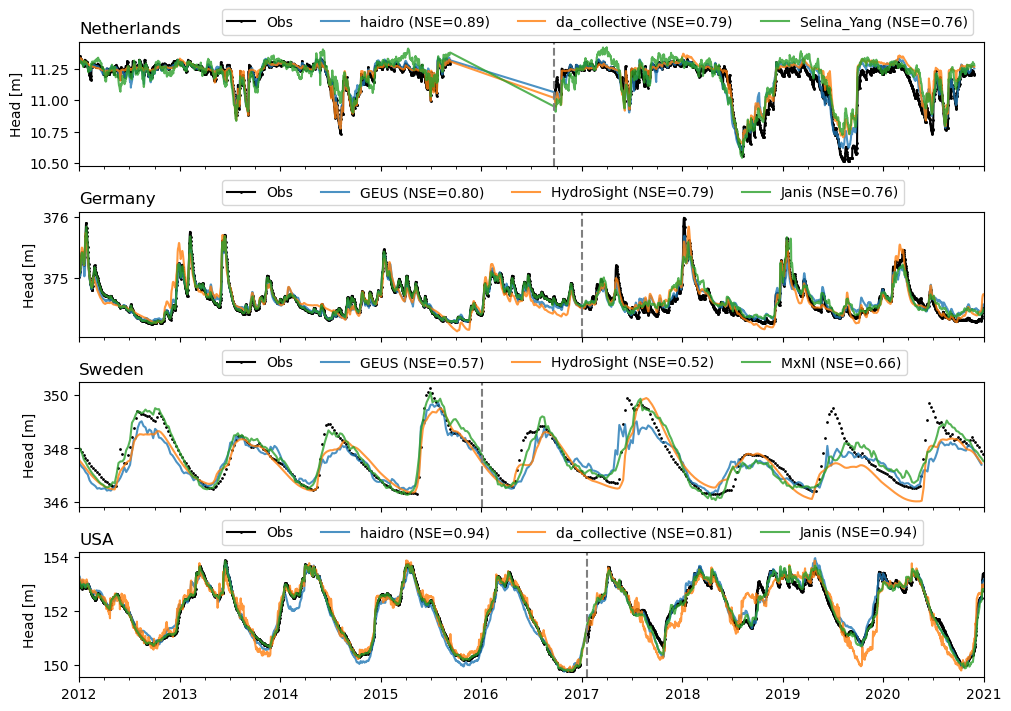

In [11]:
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True, constrained_layout=True)
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)

for i, well in enumerate(wells):
    ax= axes[i]
    
    # Plot the heads
    heads.loc["2012":, well].plot(ax=ax, marker=".", markersize=2, color="k")
    
    # Select the three best models
    best = metrics.loc[:, ("validation", "nse", well)].groupby(teams.loc[:, ("General Info", "Type")]).nlargest(1)

    for (cat, team), nse in best.items():
        sims.loc["2012":, (team, well, "Simulated Head")].dropna().plot(ax=ax, alpha=0.8)

    # Dress up the plot
    ax.set_ylabel("Head [m]")
    ax.set_title(well.split("_")[0], loc="Left")
    ax.set_xlim(["2012", "2021"])
    ax.axvline(tmin[well], linestyle="--", color="gray")
    labels = ["Obs"] + list(best.index.get_level_values(1) + best.apply(" (NSE={:.2f})".format).values)
    ax.legend(labels, ncols=4, bbox_to_anchor=(0.15, 1))
    
plt.savefig("../figures/figure_04.png", bbox_inches="tight", dpi=300)

### Figure 05: MAE$_{0.8}$ / MAE$_{0.2}$

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_73715/3010590121.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_05.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


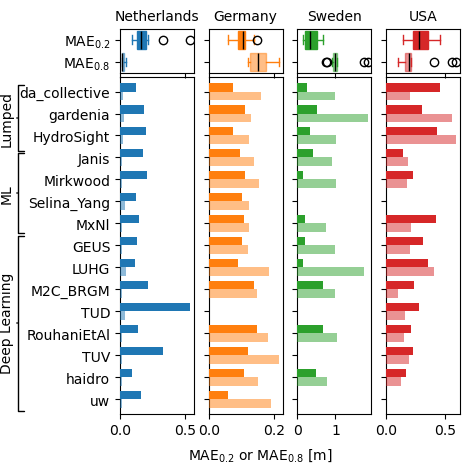

In [12]:
fig = plt.figure(figsize=(5,5),  layout="tight")
spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

top = []
axes =[]
axb = None
axt = None

for i in range(4):
    if axb is not None:
        axb = fig.add_subplot(spec[2:16, i], sharey=axb)
    else:
        axb = fig.add_subplot(spec[2:16, i])

    axes.append(axb)

    if axt is not None:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)
    else:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)

    top.append(axt)

# Get metrics values
m = metrics.loc[order, ("validation", ["mae_80", "mae_20"], wells)]
m.columns = m.columns.droplevel([0])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, well in enumerate(wells):
    ax = axes[i]
    ax.set_title("")
    ax.grid(zorder=-10)
    
    props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
    b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                           widths=0.8, color=props, patch_artist=True)
    b.patches[0].set_alpha(0.5)
    top[i].set_yticklabels(["MAE$_{0.8}$", "MAE$_{0.2}$"])
    top[i].set_title(None)
    
    m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
         color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

    top[i].set_title(well.split("_")[0], fontsize=10)
    axes[i].set_xlim(0)

# Annotate model groups
y = 0.71
plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
y = 0.56
plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
y = 0.3
plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

fig.text(0.5, 0.02, "MAE$_{0.2}$ or MAE$_{0.8}$ [m]", horizontalalignment="center")
plt.savefig("../figures/figure_05.png", bbox_inches="tight", dpi=300)

### Figure 6: PICP

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_73715/3722949100.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_06.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


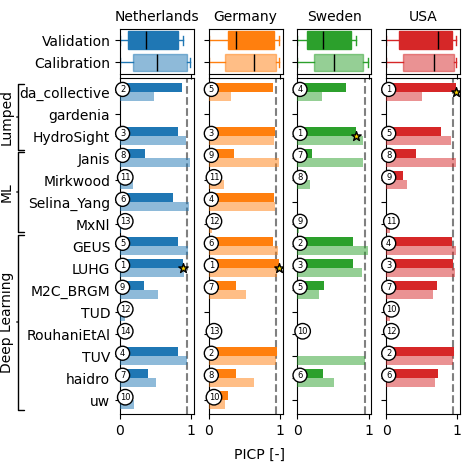

In [13]:
fig, axes = plot_metrics("PICP", label="PICP [-]", best="max")
for ax in axes:
    ax.axvline(0.95, color="gray", linestyle="--")
plt.savefig("../figures/figure_06.png", bbox_inches="tight", dpi=300)

### Figure 07: Effort and time investment

In [14]:
# teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
# teams = teams.loc[:, (["Development time", "Calibration time"], slice(None))]
# teams.head()

# fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

# for ax, well in zip(axes, wells):
#     teams.loc[order, (slice(None), well)].plot(kind="barh", zorder=10, ax=ax, legend=False, alpha=0.7, stacked=True, logx=True)
#     ax.grid(which="major", ls="-")
#     ax.set_title(well.split("_")[0])
#     #ax.set_xscale("log", base=10, subs=[1, 2, 10, 50])
#     #ax.set_xticks([1, 5, 10, 50], [0.5, 2, 10, 50])
# fig.text(0.5, 0, 'Time (hours)', ha='center')
# #axes[0].set_xlim(-0.01,1)1
# plt.legend(["Development time", "Calibration time"], ncols=2,
#            bbox_to_anchor=(-3.5,1.07), loc=3)

# plt.savefig("../figures/figure_07.png", bbox_inches="tight", dpi=300)

In [15]:
order.reverse()

In [16]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], wells)]
teams.head()

orig = teams.loc[order, :].copy()
orig[teams.loc[order, :] < 8] = 2
orig[teams.loc[order, :] < 4] = 1
orig[teams.loc[order, :] < 1] = 0
orig[teams.loc[order, :] > 8] = 3
orig = orig.stack(level=0)

df = pd.DataFrame(data=0, index=pd.MultiIndex.from_product([order, ["Development time", "Calibration time"]]),
                  columns=pd.MultiIndex.from_product([wells, [0,1,2,3]]))

for (team, period, country), group in orig.stack().items():
    df.loc[(team, period), (country, int(group))] = 1
    
df.loc[(slice(None), "Development time"), :] *= 2
df.head()

Team                           Netherlands          Germany          Sweden_2  \
                                         0  1  2  3       0  1  2  3        0   
da_collective Development time           0  0  2  0       0  0  2  0        0   
              Calibration time           0  1  0  0       0  1  0  0        0   
gardenia      Development time           2  0  0  0       2  0  0  0        2   
              Calibration time           1  0  0  0       1  0  0  0        1   
HydroSight    Development time           2  0  0  0       2  0  0  0        2   
              Calibration time           0  1  0  0       0  1  0  0        0   
Janis         Development time           2  0  0  0       0  0  2  0        2   
              Calibration time           1  0  0  0       1  0  0  0        1   
Mirkwood      Development time           0  2  0  0       0  2  0  0        0   
              Calibration time           0  1  0  0       0  1  0  0        1   
Selina_Yang   Development time           0  0  2  0       0  0  0  2        0   
              Calibration time           1  0  0  0       1  0  0  0        0   
MxNl          Development time           0  0  2  0       0  0  2  0        0   
              Calibration time           1  0  0  0       1  0  0  0        1   
GEUS          Development time           0  2  0  0       0  2  0  0        0   
              Calibration time           0  0  0  1       0  0  0  1        0   
LUHG          Development time           0  0  2  0       0  0  2  0        0   
              Calibration time           0  1  0  0       0  1  0  0        0   
M2C_BRGM      Development time           0  0  2  0       0  0  2  0        0   
              Calibration time           1  0  0  0       1  0  0  0        1   
TUD           Development time           0  0  2  0       0  0  0  0        0   
              Calibration time           0  0  0  1       0  0  0  0        0   
RouhaniEtAl   Development time           0  2  0  0       0  2  0  0        0   
              Calibration time           0  0  0  0       0  0  0  0        0   
TUV           Development time           0  2  0  0       0  0  2  0        0   
              Calibration time           1  0  0  0       1  0  0  0        1   
haidro        Development time           0  2  0  0       0  2  0  0        0   
              Calibration time           0  1  0  0       0  1  0  0        0   
uw            Development time           0  0  0  2       0  0  0  2        0   
              Calibration time           0  0  1  0       0  0  1  0        0   

Team                                    USA           
                                1  2  3   0  1  2  3  
da_collective Development time  0  2  0   0  0  2  0  
              Calibration time  1  0  0   0  1  0  0  
gardenia      Development time  0  0  0   2  0  0  0  
              Calibration time  0  0  0   1  0  0  0  
HydroSight    Development time  0  0  0   2  0  0  0  
              Calibration time  1  0  0   0  1  0  0  
Janis         Development time  0  0  0   0  2  0  0  
              Calibration time  0  0  0   1  0  0  0  
Mirkwood      Development time  2  0  0   0  2  0  0  
              Calibration time  0  0  0   1  0  0  0  
Selina_Yang   Development time  0  0  0   0  0  0  0  
              Calibration time  0  0  0   0  0  0  0  
MxNl          Development time  0  2  0   0  0  2  0  
              Calibration time  0  0  0   1  0  0  0  
GEUS          Development time  2  0  0   0  2  0  0  
              Calibration time  0  0  1   0  0  0  1  
LUHG          Development time  0  2  0   0  0  2  0  
              Calibration time  1  0  0   0  1  0  0  
M2C_BRGM      Development time  0  2  0   0  0  2  0  
              Calibration time  0  0  0   1  0  0  0  
TUD           Development time  0  0  0   2  0  0  0  
              Calibration time  0  0  0   0  0  0  1  
RouhaniEtAl   Development time  2  0  0   0  2  0  0  
              Calibration time  

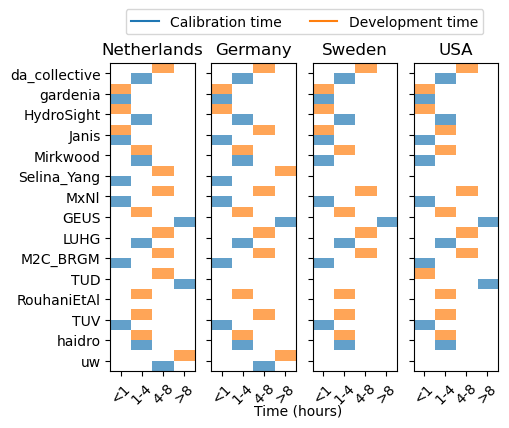

In [25]:
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

cmap = mcolors.ListedColormap(['white', 'C0', "C1"])
bounds=[0,1,2,2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for ax, well in zip(axes, wells):
    ax.imshow(df.loc[order, well].values, aspect="auto", cmap=cmap, norm=norm, alpha=0.7)
    plt.yticks(np.arange(0.5, 30.5, 2), order);
    ax.set_title(well.split("_")[0])
    ax.set_xticks([0,1,2, 3], ["<1", "1-4", "4-8", ">8"], rotation=45)
    
fig.text(0.5, 0, 'Time (hours)', ha='center')

plt.plot(np.nan, color="C0")
plt.plot(np.nan, color="C1")

plt.legend(["Calibration time", "Development time"], ncols=2,
           bbox_to_anchor=(-3.5,1.07), loc=3)

plt.savefig("../figures/figure_07.png", bbox_inches="tight", dpi=300)

### Figure: PICP example

In [19]:
# well = "Sweden_2"
# head = heads.loc["2016":, well]
# head.index = head.index.round("D")
# bounds = sims.loc["2016":, ("da_collective", well, ["95% Lower Bound", "95% Upper Bound"])].dropna()
# sim = sims.loc["2016":, ("da_collective", well, ["Simulated Head"])].dropna()

# fig, ax = plt.subplots(1,1, figsize=(5,2))

# head.plot(x_compat=True, marker=".", linestyle=" ", color="k", markersize=1)
# obs_between = head.between(bounds.loc[head.index].iloc[:,0], bounds.loc[head.index].iloc[:,1])
# head.loc[~obs_between].plot(marker="x", color="r", linestyle=" ", markersize=2)
# ax.fill_between(bounds.index, bounds.iloc[:,0].values, bounds.iloc[:,1].values, 
#                 alpha=0.5)
# sim.plot(ax=ax, legend=False)

# plt.legend(["Heads Measured", "Heads outside PI", "95% Pred. Interval", "Simulated head"], fontsize=8, ncol=2)
# ax.set_ylabel("Head [m]")
# ax.set_xlabel("")
# for tick in ax.get_xticklabels():
#     tick.set_rotation(0)

# plt.savefig("../figures/picp_example.png", bbox_inches="tight", dpi=300)

## Compute some numbers for the report

### Report average times

In [20]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], wells)]
(teams.sum(axis=1)/8).describe()

count    17.000000
mean      3.892590
std       5.042856
min       0.193056
25%       1.250000
50%       2.000000
75%       3.000000
max      19.250000
dtype: float64

### Average NSEs over all wells in validation period

In [21]:
metrics.loc[:, ("validation", "nse", slice(None))].mean().mean()

0.6411434979671584

### Excluding Sweden

In [22]:
metrics.loc[:, ("validation", "nse", ["Netherlands", "Germany", "USA"])].mean().mean()

0.719732403216343

## Average NSEs over all wells in calibration period

In [23]:
metrics.loc[:, ("calibration", "nse", slice(None))].mean().mean()

0.80477095476509

### Number of PICP less than 0.5

In [24]:
(metrics.loc[:, ("validation", "PICP", slice(None))].fillna(1) < 0.5).sum()

                  Team       
validation  PICP  Netherlands    8
                  Germany        7
                  Sweden_2       6
                  USA            5
dtype: int64